In [1]:
import plotly.express as px
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account

# Caminho com string RAW
caminho_credencial = r"C:\Users\sarah\OneDrive\Anexos\Área de Trabalho\Pos TECH\TECH_3\Credenciais\pnad-covid-analise-97b921facd04.json"

# Autenticação
credentials = service_account.Credentials.from_service_account_file(caminho_credencial)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Teste de conexão
query = """
SELECT mes, COUNT(*) as total
FROM `pnad-covid-analise.pnad_covid_data.sintomas_traduzida`
GROUP BY mes
"""

df = client.query(query).to_dataframe()
print(df)


   mes   total
0    5  349306
1    6  381270
2    7  384166


In [2]:

# Paleta profissional
paleta = ["#3B5E62", "#BDC293", "#A1B1B3", "#2D3A3B", "#EDEBE8"]

# Autenticação com a conta de serviço
caminho_credencial = r"C:\Users\sarah\OneDrive\Anexos\Área de Trabalho\Pos TECH\TECH_3\Credenciais\pnad-covid-analise-97b921facd04.json"  # Atualize aqui
credentials = service_account.Credentials.from_service_account_file(caminho_credencial)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)


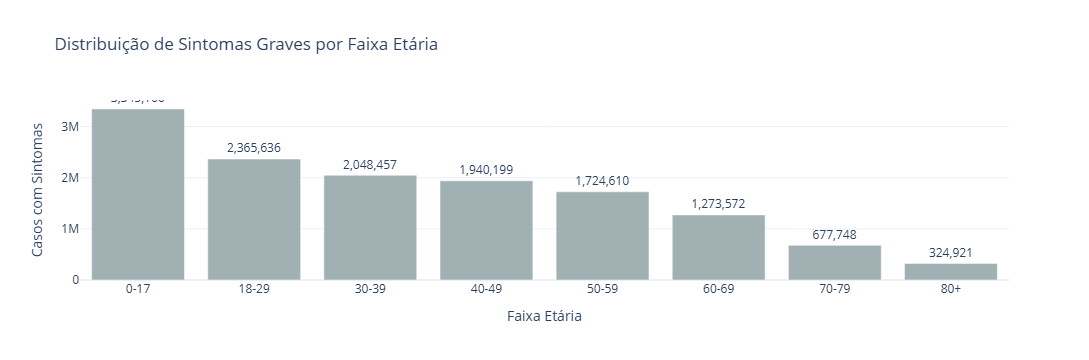

In [4]:
query = """
SELECT
  CASE
    WHEN p.Idade < 18 THEN '0-17'
    WHEN p.Idade BETWEEN 18 AND 29 THEN '18-29'
    WHEN p.Idade BETWEEN 30 AND 39 THEN '30-39'
    WHEN p.Idade BETWEEN 40 AND 49 THEN '40-49'
    WHEN p.Idade BETWEEN 50 AND 59 THEN '50-59'
    WHEN p.Idade BETWEEN 60 AND 69 THEN '60-69'
    WHEN p.Idade BETWEEN 70 AND 79 THEN '70-79'
    ELSE '80+'
  END AS faixa_etaria,
  COUNTIF(s.Febre = 'Sim' and s.Tosse = 'Sim' and s.Dificuldade_respirar = 'Sim') AS sintomas_graves
FROM `pnad-covid-analise.pnad_covid_data.sintomas_traduzida` s
JOIN `pnad-covid-analise.pnad_covid_data.populacao_traduzida` p
  ON s.UF = p.UF AND s.Numero_selecao_domicilio = p.Numero_selecao_domicilio
WHERE p.Idade IS NOT NULL
GROUP BY faixa_etaria
ORDER BY faixa_etaria
"""
df = client.query(query).to_dataframe()

fig = px.bar(df, x="faixa_etaria", y="sintomas_graves",
             text="sintomas_graves",
             title="Distribuição de Sintomas Graves por Faixa Etária",
             labels={"faixa_etaria": "Faixa Etária", "sintomas_graves": "Casos com Sintomas"},
             color_discrete_sequence=["#A1B1B3"])

fig.update_traces(texttemplate='%{text:,}', textposition='outside')
fig.update_layout(template='plotly_white', uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()


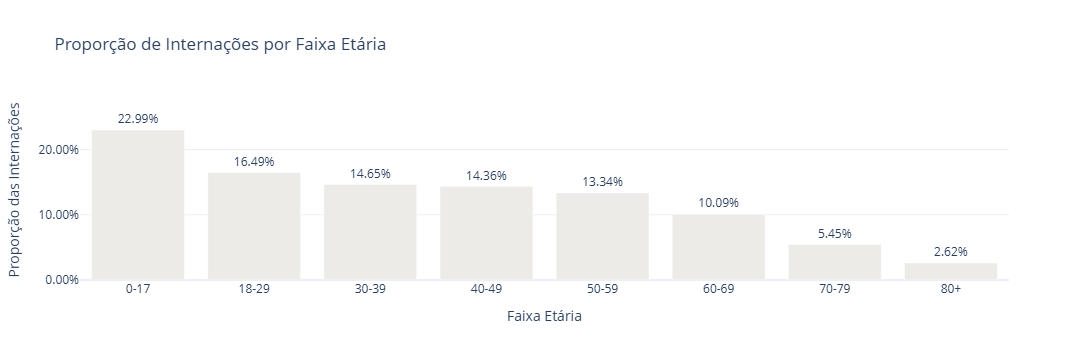

In [5]:
query = """
SELECT
  CASE
    WHEN p.Idade < 18 THEN '0-17'
    WHEN p.Idade BETWEEN 18 AND 29 THEN '18-29'
    WHEN p.Idade BETWEEN 30 AND 39 THEN '30-39'
    WHEN p.Idade BETWEEN 40 AND 49 THEN '40-49'
    WHEN p.Idade BETWEEN 50 AND 59 THEN '50-59'
    WHEN p.Idade BETWEEN 60 AND 69 THEN '60-69'
    WHEN p.Idade BETWEEN 70 AND 79 THEN '70-79'
    ELSE '80+'
  END AS faixa_etaria,
  COUNTIF(s.Internacao_hospitalar = 'Sim') AS internacoes
FROM `pnad-covid-analise.pnad_covid_data.sintomas_traduzida` s
JOIN `pnad-covid-analise.pnad_covid_data.populacao_traduzida` p
  ON s.UF = p.UF AND s.Numero_selecao_domicilio = p.Numero_selecao_domicilio
GROUP BY faixa_etaria
ORDER BY faixa_etaria
"""
df = client.query(query).to_dataframe()

# Calcular proporção em relação ao total de internações
total_internacoes = df["internacoes"].sum()
df["proporcao"] = df["internacoes"] / total_internacoes

# Gráfico com proporção
fig = px.bar(df, x="faixa_etaria", y="proporcao", text="proporcao",
             title="Proporção de Internações por Faixa Etária",
             labels={"faixa_etaria": "Faixa Etária", "proporcao": "Proporção das Internações"},
             color_discrete_sequence=["#EDEBE8"])
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(template='plotly_white')
fig.update_yaxes(tickformat=".2%", range=[0, df["proporcao"].max() * 1.2])
fig.show()


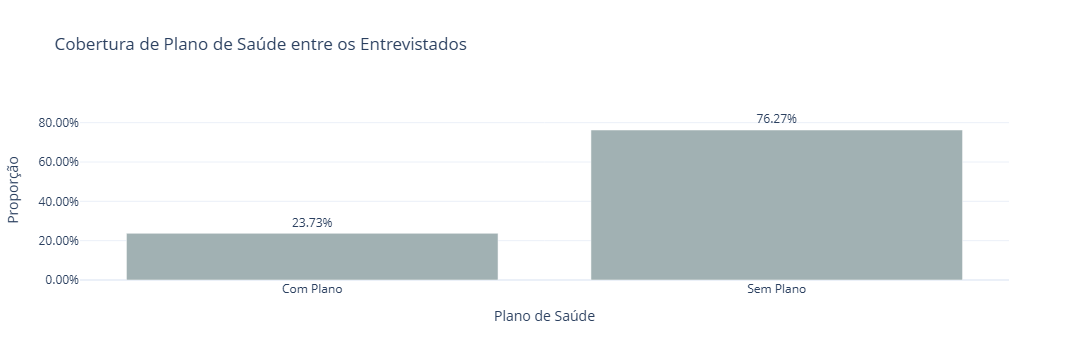

In [18]:
query = """
SELECT Plano_de_saude, COUNT(*) AS total
FROM `pnad-covid-analise.pnad_covid_data.sintomas_traduzida`
GROUP BY Plano_de_saude
"""
df = client.query(query).to_dataframe()

# Forçar tipo string para segurança
df["Plano_de_saude"] = df["Plano_de_saude"].astype(str)

# ✅ Corrigir: filtro para "Sim" e "Nao" (sem acento)
df = df[df["Plano_de_saude"].isin(["Sim", "Nao"])]

# ✅ Mapear rótulos finais corretamente
df["Plano_de_saude"] = df["Plano_de_saude"].replace({
    "Sim": "Com Plano", "Nao": "Sem Plano"
})

# Calcular proporção
total_geral = df["total"].sum()
df["proporcao"] = df["total"] / total_geral

# Plotar
fig = px.bar(df, x="Plano_de_saude", y="proporcao", text="proporcao",
             title="Cobertura de Plano de Saúde entre os Entrevistados",
             labels={"Plano_de_saude": "Plano de Saúde", "proporcao": "Proporção"},
             color_discrete_sequence=["#A1B1B3"])
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(template='plotly_white')
fig.update_yaxes(tickformat=".2%", range=[0, df["proporcao"].max() * 1.2])
fig.show()


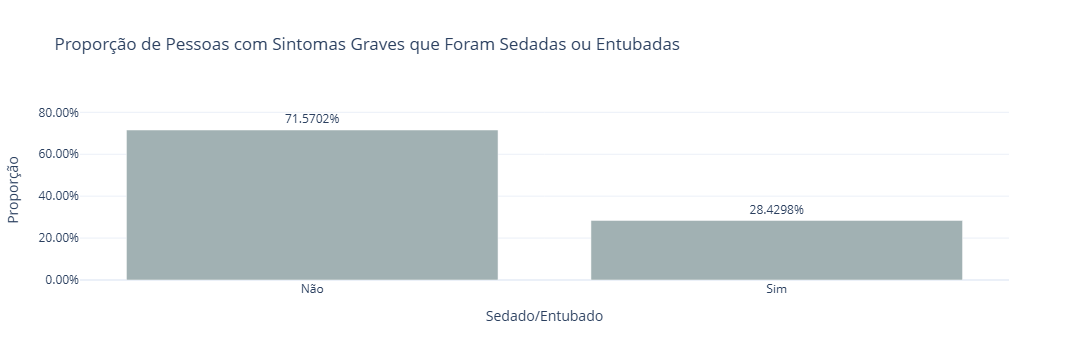

In [20]:
query = """
SELECT Sedado_entubado, COUNT(*) AS total
FROM `pnad-covid-analise.pnad_covid_data.sintomas_traduzida`
WHERE Febre = 'Sim' OR Tosse = 'Sim' OR Dificuldade_respirar = 'Sim'
GROUP BY Sedado_entubado
"""
df = client.query(query).to_dataframe()

# Corrigir o tipo e garantir correspondência
df["Sedado_entubado"] = df["Sedado_entubado"].astype(str)

# ✅ Filtro correto com 'Sim' e 'Nao'
df = df[df["Sedado_entubado"].isin(["Sim", "Nao"])]

# ✅ Rótulos legíveis
df["Sedado_entubado"] = df["Sedado_entubado"].replace({
    "Sim": "Sim", "Nao": "Não"
})

# Proporção sobre total com sintomas graves
total_graves = df["total"].sum()
df["proporcao"] = df["total"] / total_graves

# Gráfico final
fig = px.bar(df, x="Sedado_entubado", y="proporcao", text="proporcao",
             title="Proporção de Pessoas com Sintomas Graves que Foram Sedadas ou Entubadas",
             labels={"Sedado_entubado": "Sedado/Entubado", "proporcao": "Proporção"},
             color_discrete_sequence=["#A1B1B3"])
fig.update_traces(texttemplate='%{text:.4%}', textposition='outside')
fig.update_layout(template='plotly_white')
fig.update_yaxes(tickformat=".2%", range=[0, df["proporcao"].max() * 1.2])
fig.show()


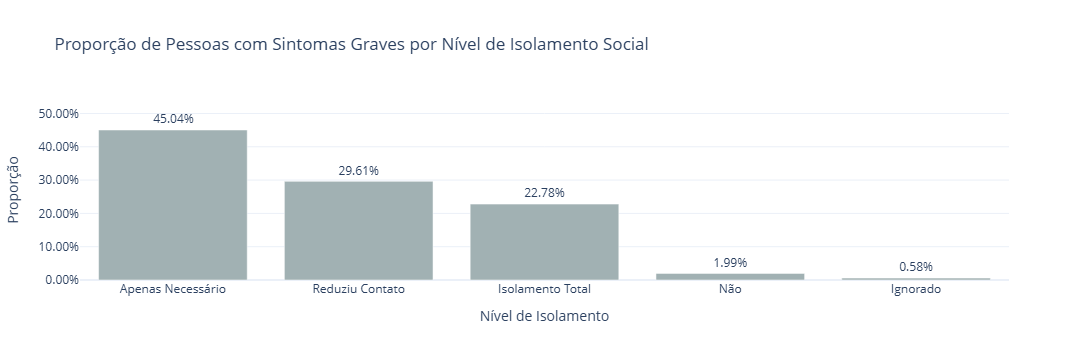

In [14]:
query = """
SELECT
  Restringiu_contato,
  COUNT(*) AS total
FROM `pnad-covid-analise.pnad_covid_data.comportamento_traduzida` c
JOIN `pnad-covid-analise.pnad_covid_data.sintomas_traduzida` s
  ON c.UF = s.UF AND c.Numero_selecao_domicilio = s.Numero_selecao_domicilio
WHERE s.Febre = 'Sim' OR s.Tosse = 'Sim' OR s.Dificuldade_respirar = 'Sim'
GROUP BY Restringiu_contato
"""
df = client.query(query).to_dataframe()

# Exemplo: se os valores forem strings legíveis (ajuste conforme necessário)
mapa_isolamento = {
    "Nao": "Não",
    "Reduziu_contato": "Reduziu Contato",
    "Apenas_necessario": "Apenas Necessário",
    "Isolamento_total": "Isolamento Total",
    "Ignorado": "Ignorado"
}

# Aplicar mapeamento real
df["Nivel_Isolamento"] = df["Restringiu_contato"].map(mapa_isolamento)
df = df[df["Nivel_Isolamento"].notnull()]

# Calcular proporção sobre total de pessoas com sintomas graves
total_graves = df["total"].sum()
df["proporcao"] = df["total"] / total_graves

# Ordenar
df = df.sort_values("proporcao", ascending=False)

# Gráfico
fig = px.bar(df, x="Nivel_Isolamento", y="proporcao", text="proporcao",
             title="Proporção de Pessoas com Sintomas Graves por Nível de Isolamento Social",
             labels={"Nivel_Isolamento": "Nível de Isolamento", "proporcao": "Proporção"},
             color_discrete_sequence=["#A1B1B3"])

fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(template='plotly_white')
fig.update_yaxes(tickformat=".2%", range=[0, df["proporcao"].max()*1.2])
fig.show()


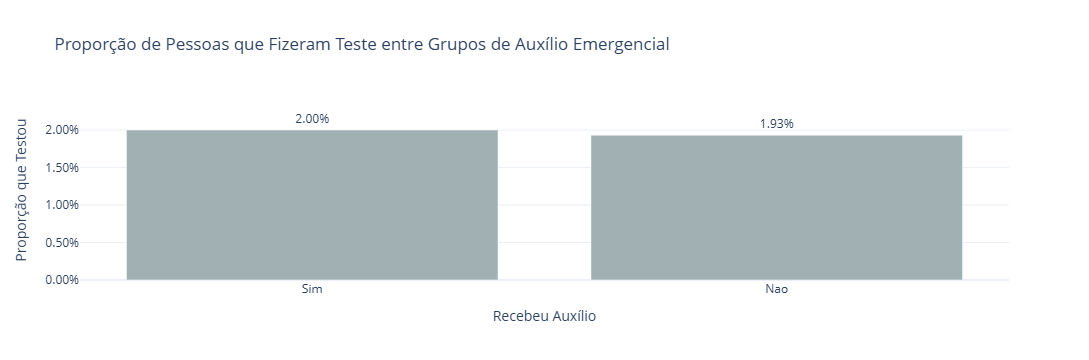

In [11]:
query = """
SELECT
  Recebeu_auxilio_emergencial,
  COUNTIF(Fez_teste_covid = 'Sim') AS testou,
  COUNT(*) AS total
FROM `pnad-covid-analise.pnad_covid_data.economia_traduzida` e
JOIN `pnad-covid-analise.pnad_covid_data.comportamento_traduzida` c
  ON e.UF = c.UF AND e.Numero_selecao_domicilio = c.Numero_selecao_domicilio
WHERE Recebeu_auxilio_emergencial IN ('Sim', 'Nao')
GROUP BY Recebeu_auxilio_emergencial
"""
df = client.query(query).to_dataframe()

# Calcular proporção correta dentro de cada grupo
df["proporcao"] = df["testou"] / df["total"]

# Ordenar visualmente
df = df.sort_values("proporcao", ascending=False)

# Gráfico
fig = px.bar(df, x="Recebeu_auxilio_emergencial", y="proporcao", text="proporcao",
             title="Proporção de Pessoas que Fizeram Teste entre Grupos de Auxílio Emergencial",
             labels={"Recebeu_auxilio_emergencial": "Recebeu Auxílio", "proporcao": "Proporção que Testou"},
             color_discrete_sequence=["#A1B1B3"])
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(template='plotly_white')
fig.update_yaxes(tickformat=".2%", range=[0, df["proporcao"].max() * 1.2])
fig.show()


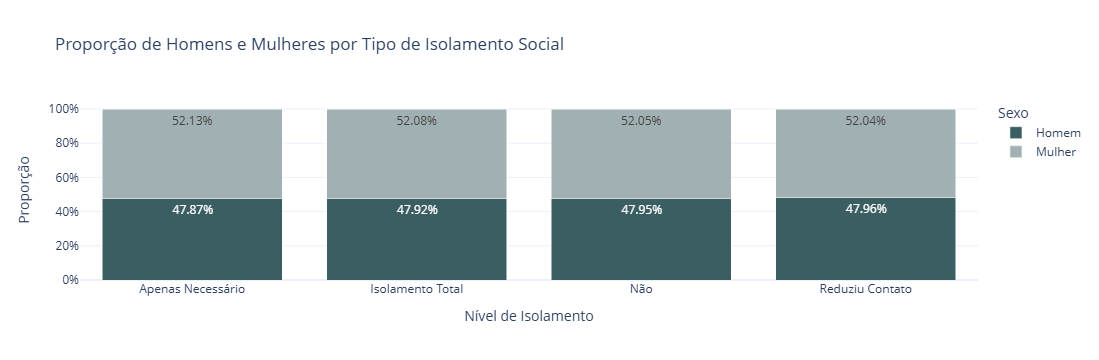

In [29]:
query = """
SELECT p.Sexo, c.Restringiu_contato, COUNT(*) AS total
FROM `pnad-covid-analise.pnad_covid_data.populacao_traduzida` p
JOIN `pnad-covid-analise.pnad_covid_data.comportamento_traduzida` c
  ON p.UF = c.UF AND p.Numero_selecao_domicilio = c.Numero_selecao_domicilio
WHERE p.Sexo IS NOT NULL AND c.Restringiu_contato IS NOT NULL
GROUP BY p.Sexo, c.Restringiu_contato
"""
df = client.query(query).to_dataframe()

# Mapear rótulos com segurança
df["Sexo"] = df["Sexo"].astype(str).replace({
    "1": "Homem", "2": "Mulher", "9": "Ignorado"
})
df["Isolamento"] = df["Restringiu_contato"].astype(str).replace({
    "Nao": "Não",
    "Reduziu_contato": "Reduziu Contato",
    "Apenas_necessario": "Apenas Necessário",
    "Isolamento_total": "Isolamento Total",
    "Ignorado": "Ignorado"
})

# Filtrar válidos
df = df[df["Sexo"].isin(["Homem", "Mulher"])]
df = df[df["Isolamento"] != "Ignorado"]

# Calcular proporção dentro de cada tipo de isolamento
df_group = df.groupby("Isolamento")["total"].transform("sum")
df["proporcao"] = df["total"] / df_group

# Gráfico
fig = px.bar(df, x="Isolamento", y="proporcao", color="Sexo", barmode="stack",
             title="Proporção de Homens e Mulheres por Tipo de Isolamento Social",
             labels={"Isolamento": "Nível de Isolamento", "proporcao": "Proporção"},
             color_discrete_sequence=["#3B5E62", "#A1B1B3"])
fig.update_traces(texttemplate='%{y:.2%}', textposition='inside')
fig.update_layout(template='plotly_white', yaxis_tickformat=".0%")
fig.show()


In [ ]:
query = """
SELECT
  CASE
    WHEN p.UF IN ('SP', 'RJ', 'MG', 'RS', 'SC', 'PR', 'DF') THEN 'Urbano'
    ELSE 'Rural'
  END AS tipo_localidade,
  COUNTIF(s.Internacao_hospitalar = 'Sim') AS internacoes,
  COUNT(*) AS total
FROM `pnad-covid-analise.pnad_covid_data.populacao_traduzida` p
JOIN `pnad-covid-analise.pnad_covid_data.sintomas_traduzida` s
  ON p.UF = s.UF AND p.Numero_selecao_domicilio = s.Numero_selecao_domicilio
GROUP BY tipo_localidade
"""
df = client.query(query).to_dataframe()
df["proporcao"] = df["internacoes"] / df["total"]

fig = px.bar(df, x="tipo_localidade", y="proporcao", text="proporcao",
             title="Proporção de Internações por Localidade",
             color_discrete_sequence=["#A1B1B3"])
fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig.update_layout(template='plotly_white')
fig.show()


In [ ]:
query = """
SELECT
  s.UF,
  COUNTIF(s.Febre = 'Sim' OR s.Tosse = 'Sim' OR s.Dificuldade_respirar = 'Sim') AS sintomas_graves
FROM `pnad-covid-analise.pnad_covid_data.sintomas_traduzida` s
GROUP BY s.UF
"""
df = client.query(query).to_dataframe()

# Ajustar códigos da UF para formato de sigla (necessário para mapa do Brasil)
uf_map = {
    11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
    21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE', 29: 'BA',
    31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP',
    41: 'PR', 42: 'SC', 43: 'RS',
    50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'
}
df['UF'] = df['UF'].astype(int).map(uf_map)

fig = px.choropleth(df,
    locations='UF',
    locationmode='ISO-3166-2',
    color='sintomas_graves',
    color_continuous_scale='Tealgrn',
    scope='south america',
    title='Sintomas Graves por Estado (UF) – Mapa Interativo',
    labels={'sintomas_graves': 'Total de Casos'}
)

fig.update_layout(template='plotly_white')
fig.show()


In [ ]:
query = """
SELECT
  c.UF,
  COUNTIF(c.Resultado_teste_covid_um = 'Positivo') AS casos_confirmados
FROM `pnad-covid-analise.pnad_covid_data.comportamento_traduzida` c
GROUP BY c.UF
"""
df = client.query(query).to_dataframe()

# Mapear código da UF para sigla (necessário para plotly)
uf_map = {
    11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
    21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE', 29: 'BA',
    31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP',
    41: 'PR', 42: 'SC', 43: 'RS',
    50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'
}
df['UF'] = df['UF'].astype(int).map(uf_map)

# Mapa com Plotly
fig = px.choropleth(df,
    locations='UF',
    locationmode='ISO-3166-2',
    color='casos_confirmados',
    color_continuous_scale='Reds',
    scope='south america',
    title='Casos Confirmados por Teste (Positivos) por Estado (UF)',
    labels={'casos_confirmados': 'Casos Confirmados'}
)

fig.update_layout(template='plotly_white')
fig.show()


In [ ]:
query = """
SELECT
  Faixa_rendimento,
  COUNTIF(Recebeu_auxilio_emergencial = 'Sim') AS recebeu_auxilio,
  COUNT(*) AS total
FROM `pnad-covid-analise.pnad_covid_data.economia_traduzida`
GROUP BY Faixa_rendimento
ORDER BY Faixa_rendimento
"""
df = client.query(query).to_dataframe()
df["proporcao"] = df["recebeu_auxilio"] / df["total"]

fig = px.bar(df, x="Faixa_rendimento", y="proporcao", text="proporcao",
             title="Correlação: Faixa de Renda x Recebimento de Auxílio Emergencial",
             labels={"proporcao": "Proporção que Recebeu Auxílio"},
             color_discrete_sequence=["#A1B1B3"])
fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig.update_layout(template='plotly_white')
fig.show()


In [ ]:
query = """
SELECT
  p.Escolaridade,
  COUNTIF(c.Fez_teste_covid = 'Sim') AS testou,
  COUNT(*) AS total
FROM `pnad-covid-analise.pnad_covid_data.populacao_traduzida` p
JOIN `pnad-covid-analise.pnad_covid_data.comportamento_traduzida` c
  ON p.UF = c.UF AND p.Numero_selecao_domicilio = c.Numero_selecao_domicilio
GROUP BY p.Escolaridade
"""
df = client.query(query).to_dataframe()
df["proporcao"] = df["testou"] / df["total"]

fig = px.bar(df, x="Escolaridade", y="proporcao", text="proporcao",
             title="Correlação: Escolaridade x Realização de Teste",
             labels={"proporcao": "Proporção que Realizou Teste"},
             color_discrete_sequence=["#A1B1B3"])
fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig.update_layout(template='plotly_white', xaxis_tickangle=-45)
fig.show()


In [ ]:
query = """
SELECT
  e.Trabalhou_remotamente,
  COUNTIF(s.Febre = 'Sim' OR s.Tosse = 'Sim' OR s.Dificuldade_respirar = 'Sim') AS com_sintoma,
  COUNT(*) AS total
FROM `pnad-covid-analise.pnad_covid_data.economia_traduzida` e
JOIN `pnad-covid-analise.pnad_covid_data.sintomas_traduzida` s
  ON e.UF = s.UF AND e.Numero_selecao_domicilio = s.Numero_selecao_domicilio
GROUP BY Trabalhou_remotamente
"""
df = client.query(query).to_dataframe()
df = df[df["Trabalhou_remotamente"].isin(["Sim", "Não"])]
df["proporcao"] = df["com_sintoma"] / df["total"]

fig = px.bar(df, x="Trabalhou_remotamente", y="proporcao", text="proporcao",
             title="Correlação: Trabalho Remoto x Sintomas Respiratórios",
             labels={"proporcao": "Proporção com Sintomas"},
             color_discrete_sequence=["#A1B1B3"])
fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig.update_layout(template='plotly_white')
fig.show()
